In [98]:
import numpy as np
import cv2
cv2.ocl.setUseOpenCL(False)
from matplotlib import pyplot as plt
import contamination_detection

## Load images, one contaminated and other one not contaminated

In [139]:
path = "/home/natalija/Documents/HackZurich/contamination_detection/contamination1.jpg"
no_path = "/home/natalija/Documents/HackZurich//contamination_detection/no_contamination1.jpg"

image = cv2.imread(path, 0)
no_image = cv2.imread(no_path, 0)

## Load mask

In [173]:
src= contamination_detection.feature_image(path)

ret, thresh = cv2.threshold(image.astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# You need to choose 4 or 8 for connectivity type
connectivity = 4
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
print(num_labels)
# The second cell is the label matrix
labels = output[1]
print(labels)
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

print(len(centroids))

3249
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
3249


## Fourier transform

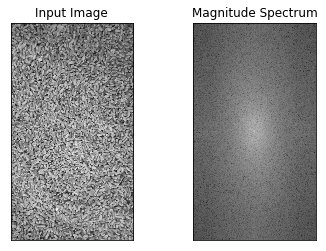

In [153]:
f = np.fft.fft2(no_image)
fshift = np.fft.fftshift(f)
no_magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(no_image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(no_magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

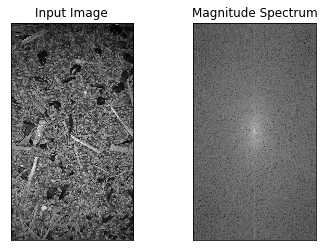

In [156]:
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

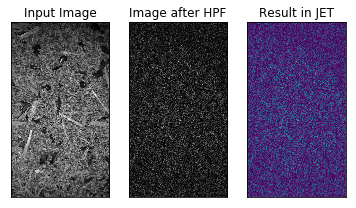

In [155]:
rows, cols = image.shape
crow , ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

## Blob detection 
https://www.learnopencv.com/blob-detection-using-opencv-python-c/

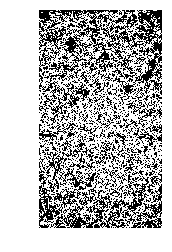

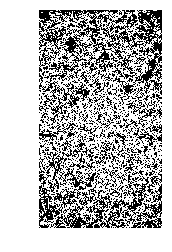

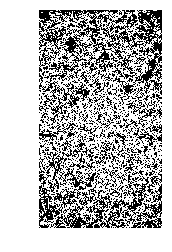

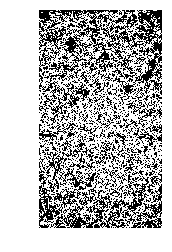

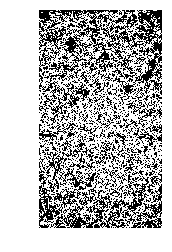

In [40]:
# Read image
im = cv2.imread('/home/natalija/Documents/HackZurich/contamination_detection/contamination1.jpg', cv2.IMREAD_GRAYSCALE)
# Set up the detector with default parameters.
d = cv2.Canny(im, 0, 230 )
for i in range(5): 
    d = cv2.dilate(d, None, iterations=1)
    D = cv2.blur(d, (5,5))
    d = cv2.erode(d, None, iterations=1)
    plt.axis("off")
    plt.imshow(d, "gray")
    plt.show()

## Detect feature in image, one by one all 8
https://www.learnopencv.com/blob-detection-using-opencv-python-c/
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

Not enough matches are found - 3/10


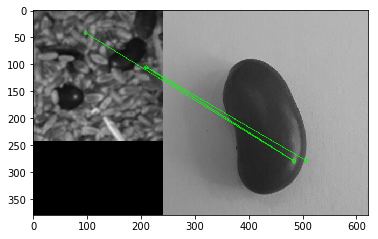

(<matplotlib.image.AxesImage at 0x7f7882f4b4e0>, None)

In [49]:
MIN_MATCH_COUNT = 10

img1 = cv2.imread('/home/natalija/Documents/HackZurich/contamination_detection/contamination1_f.jpg',0)  # queryImage
img2 = cv2.imread('/home/natalija/Documents/HackZurich/contamination_detection/first.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

img1 = cv2.blur(img1, (5,5))

FLANN_INDEX_KDTREE = 0

flann = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.85*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()

## Take a picture with the camera and save it

In [129]:
def take_picture(path):
    camera = cv2.VideoCapture(0) # video capture source camera (Here webcam of laptop) 
    ret,frame = camera.read() # return a single frame in variable `frame`
    cv2.imwrite(path,frame)
    cv2.destroyAllWindows()
    cap.release()

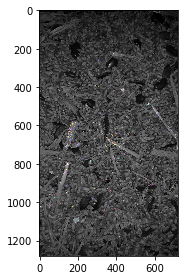

In [135]:
from skimage.io import imread, imshow
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from numpy import percentile
import matplotlib.pyplot as plt

from spade.detection_2d import spade2d
from spade.shapes.examples import potatoids5x5_smallest4px


# Load the example image.
image = cv2.imread('/home/natalija/Documents/HackZurich/contamination_detection/contamination1.jpg', 0)

# Separate cell image from background, using by Otsu's thresholding method.
cell = image > threshold_otsu(image)


# Focus on brightest pixels only
potential_centers = image > percentile(image[cell], 10)

# Detect particles.
particles = spade2d(image=image,
                    shapes_library=potatoids5x5_smallest4px,
                    threshold=20,
                    potential_centers=potential_centers,
                    mask=cell)

# Show detected particles as overlay on our original image.
imshow(label2rgb(particles, image, bg_label=0))
plt.show()